# One armed bandits 

The one armed bandit is a slang for the slot machines in casinos.

![](media/chapter-2/one-armed-bandit.jpg)

The action here is the pulling of the lewer. Each action costs a certain amount of money. The reward is unknown. If we have a fixed budget of money and we have multiple slot machines, we may want to have a strategy as to what machine to pull. If we spend all or our money on one slot machine, we can never know what is the average return of another. 

# K - armed bandits 

![](media/chapter-2/k-armed-bandits.png)

In practise, a common problem RL tries to solve is the so called k - armed bandit problem. The $K$ in the name refers to all the possible actions that an agent can take at a given time step $t$. As in the picture above, the agent (in our case, an octopus) can choose to pull one of the $K$ levers. 

The simplest formulation of the k-armed problem is `to find which bandit gives the highest reward without any other piece of information`. 

A more standart formulation is to `maximize the expected total reward over some time period, for example,
over 1000 action selections, or time steps`.

# K - armed bandit simulation 

Let us assume that we know the distribution of returns for each bandit. We can simulate the returns of each bandit by sampling from the distribution.


In [1]:
# Importing the randomnes generator 
import numpy as np

# Importing the plotting library
import matplotlib.pyplot as plt
import seaborn as sns 

# Dataframe creation 
import pandas as pd

# Iteration tracking 
from tqdm import tqdm 

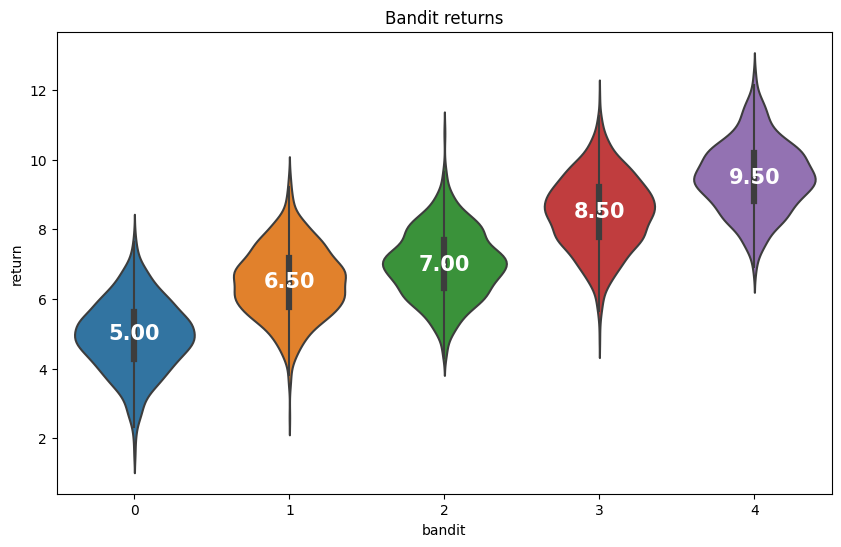

In [2]:
# Creating 5 bandits each with different normal distributions 
means = [5, 6.5, 7, 8.5, 9.5]

# Generating the returns for each bandit
bandits = [np.random.normal(m, 1, 1000) for m in means]

# Creating a dataframe for the returns
df = pd.DataFrame(bandits).T 

# Melting the dataframe
df = pd.melt(df)
df.columns=['bandit', 'return']

# Ploting the returns for each bandit
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='bandit', y='return', data=df, ax=ax)

# Adding the labels of  the mean returns
for i, m in enumerate(means):
    # The background color of the text is set to white
    ax.text(i, m, f'{m:.2f}', ha='center', va='center', color='white', fontsize=15, fontweight='bold')

ax.set_title('Bandit returns')
plt.show()


We, the creators of the bandits, know that the best strategy is to always play on the 5th bandit, because the mean reward after each pull is the highest. The problem is that an agent does not know this. It has to learn by itself.

# Explotation vs exploration 

One of the fundamental problems in reinforced learning is the explotation vs exploration part.  

**Exploration** allows an agent to improve its current knowledge about each action, hopefully leading to long-term benefit. Improving the accuracy of the estimated action-values, enables an agent to make more informed decisions in the future.

**Exploitation** on the other hand, chooses the greedy action to get the most reward by exploiting the agent’s current action-value estimates. But by being greedy with respect to action-value estimates, and agent may not actually get the most reward and lead to sub-optimal behaviour. 

When an agent explores, it gets more accurate estimates of action-values. And when it exploits, it might get more reward. It cannot, however, choose to do both simultaneously, which is also called the `exploration-exploitation dilemma`.

# Notations 

$\mathbb{A} = \{a_{1}, a_{2}, ..., a_{n}\}$ - all the available actions our agent can take.  

$A_{t}$ - action taken at time step $t$.

$R_{t} \in \mathbb{R}$ - the reward at time step $t$. 

$q_{*}(a) = \mathbb{E}\left[R_{t} | A_{t} = a\right]$ - the expected value of action $a$, also called the optimal action value. 

$Q_{t}(a)$ - the estimated value of action $a$ at time step $t$. We would like to estimate this value as close as possible to the optimal action value $q_{*}(a)$. 

# Exploration and exploitation in k - armed bandits 

## Action - value estimation 

In our 5 armed bandit example, the set of all possible actions is: 

$$ A = \{0, 1, 2, 3, 4\} $$

The action value estimate at time step $t$ for a given action $a$ has a recursive definition:

$$ Q_{t}(a) = Q_{t-1}(a) + \alpha \left[R_{t-1} - Q_{t-1}(a)\right] $$

$ \forall a \in A$

$\alpha \in [0, 1]$

The greedy action is an action that: 

$$ a_{greedy} = \underset{a \in A}{\operatorname{argmax}} Q_{t}(a) $$

## Action - value estimation in practise 

Let us clearify the theoretical examples with the help of a coding example. 

Imagine that you are an RL agent and see 5 bandit machines for the first time. Your creators want you to come up with the optimal strategy of winning. Thus, initialy, the action values are set to 0. 

In [3]:
def init_Q(n_bandits):
    """Initialize the action-value function Q with zeros"""
    Q = np.zeros(n_bandits)
    return Q

# Setting the initial action - values for the bandits to be 0 
Q = init_Q(len(means)) 
print(Q)

[0. 0. 0. 0. 0.]


As it stands, there were no actions taken and thus every action value is 0. Let us define the function that updates the given action value estimate with the new reward.

In [4]:
def select_action(Q:list, epsilon: float = 1.0) -> int:
    """
    Selects an action using the epsilon-greedy policy.

    If espilon is 1, the action is selected randomly.
    If epsilon is 0, the action is selected greedily.
    """
    if (np.random.random() < epsilon) or (np.all(Q == 0)):
        action = np.random.choice(range(len(Q)))
    else:
        action = np.argmax(Q)
    return action

# Defining the reward for each action 
rewards_generator = {
    0: lambda: np.random.normal(means[0], 1),
    1: lambda: np.random.normal(means[1], 1),
    2: lambda: np.random.normal(means[2], 1),
    3: lambda: np.random.normal(means[3], 1),
    4: lambda: np.random.normal(means[4], 1)
}

# Defining the function that gets the reward based on the action
def get_reward(action: int) -> float:
    return rewards_generator[action]()

def update_Q(Q:list, action: int, alpha: float = 0.1) -> list:
    """
    Updates the action-value function using the sample-average method.
    """
    Q[action] += alpha * (get_reward(action) - Q[action])
    return Q

Now lets do one simulation and see what is the result.

In [6]:
# Selecting a random action
action = select_action(Q, epsilon = 1.0) 

# Getting the rewward 
reward = get_reward(action)

# Updating the action-value function
Q = update_Q(Q, action)
print(Q)

[0.         0.         0.         0.88966708 0.99287811]


As we can see the robot has taken one action ant that action produced a certain reward. If we would instruct our agent to now maximize the reward, he would only make the choice that he has made. But we want him to learn and maybe other bandits are better than the one he has seen. 

## Pure exploration algorithm

Let us simulate the case where our algorithm only chooses the bandit to use randomly. 

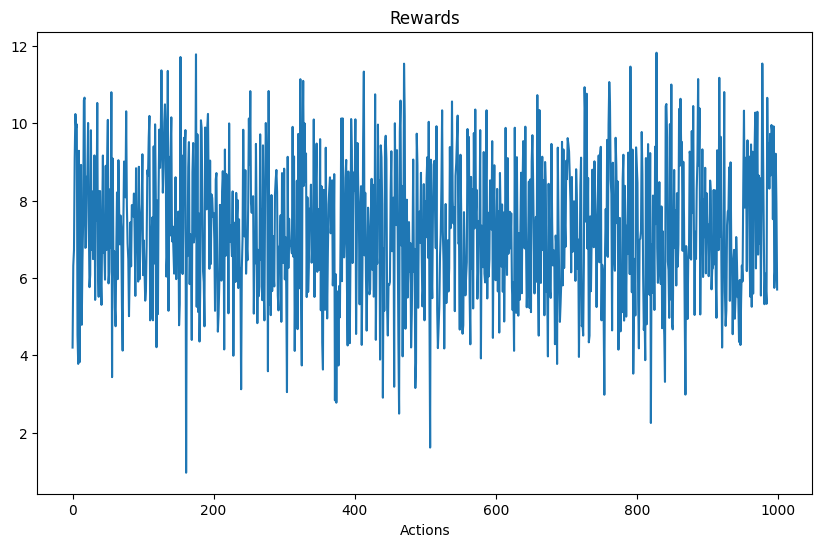

In [7]:
# Defining the number of actions 
n_actions = 1000
rewards = []
Q = init_Q(len(means))
for action in range(n_actions):
    # Selecting an action
    action = select_action(Q, epsilon = 1.0) 

    # Getting the rewward 
    reward = get_reward(action)

    # Appending to the list of rewards
    rewards.append(reward)

# Plotting the rewards
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(rewards)
ax.set_title('Rewards')
ax.set_xlabel('Actions')
plt.show()


## Epsilon greedy algorithm 

You may have seen in the `select_action()` function that there is a parameter titled `epsilon`. This parameter is also known as the `exploration rate`. For a subset of time steps, we say to our agent that instead of chosing the best action **seen so far**, he should explore and try out other actions. 

Thus, by default, our agent choses the argument that maximizes the action value estimate: 

$$\argmax_{a} Q_{t}(a)$$ 

This is called the `greedy` action. The $\epsilon$ - greedy algorithm is a simple way to balance exploration and exploitation by alowing our agent to explore the space of actions with a probability of $\epsilon$.  

In the epislon-greedy algorithm analysis, we tend to do the runs thousands of times and then average the rewards at each time step.

In [8]:
# Defining the lists of epsilon
epsilons = [0.0, 0.1, 0.4, 0.8, 1.0]

# Defining the number of actions per run
n_actions = 500

# Defining the number of runs 
n_runs = 2000

# Master dataframe 
d = pd.DataFrame()
Q_df = pd.DataFrame()

for epsilon in tqdm(epsilons):
    runs = []
    Q_run = []
    for run in range(n_runs):
        rewards = []
        Q = init_Q(len(means))
        for action in range(n_actions):
            # Selecting an action
            action = select_action(Q, epsilon = epsilon) 

            # Getting the rewward 
            reward = get_reward(action)

            # Updating the action-value function
            Q = update_Q(Q, action)

            # Appending to the list of rewards
            rewards.append(reward)

        # Appending the rewards to the runs
        runs = np.append(runs, rewards)

        # Appending the action-value function to the list of action-value functions
        Q_run.append(Q)
    
    # Averaging the Q_run and appending to Q_eval 
    Q_run = np.mean(Q_run, axis=0)

    # Converting to dataframe 
    Q_run = pd.DataFrame(Q_run, columns=['Q'])
    Q_run['bandit'] = Q_run.index
    Q_run['epsilon'] = epsilon

    Q_df = pd.concat([Q_df, Q_run])

    # Averaging 
    runs = runs.reshape(n_runs, n_actions)
    runs = runs.mean(axis=0)

    df = pd.DataFrame(runs, columns=['reward'])
    df['epsilon'] = epsilon
    df['step'] = df.index

    d = pd.concat([d, df])

100%|██████████| 5/5 [00:51<00:00, 10.22s/it]


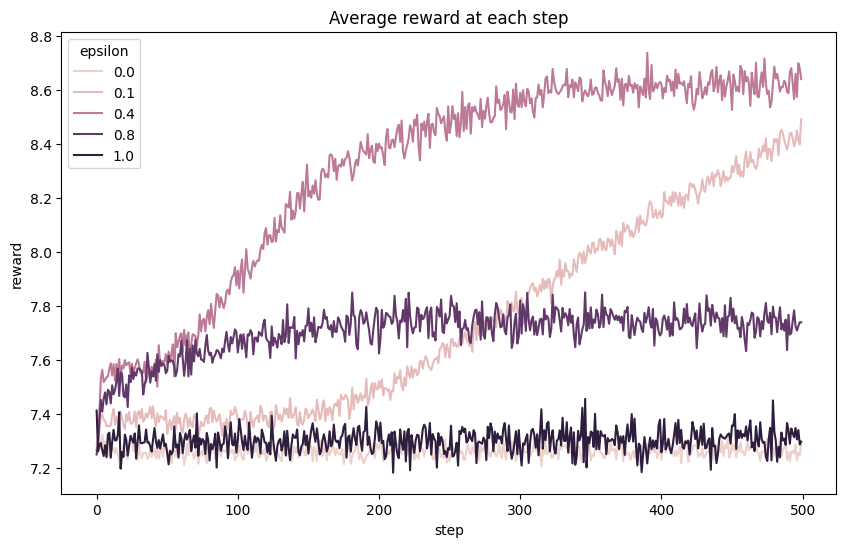

In [9]:
# Plotting the rewards
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='step', y='reward', hue='epsilon', data=d, ax=ax)
ax.set_title('Average reward at each step')
plt.show()

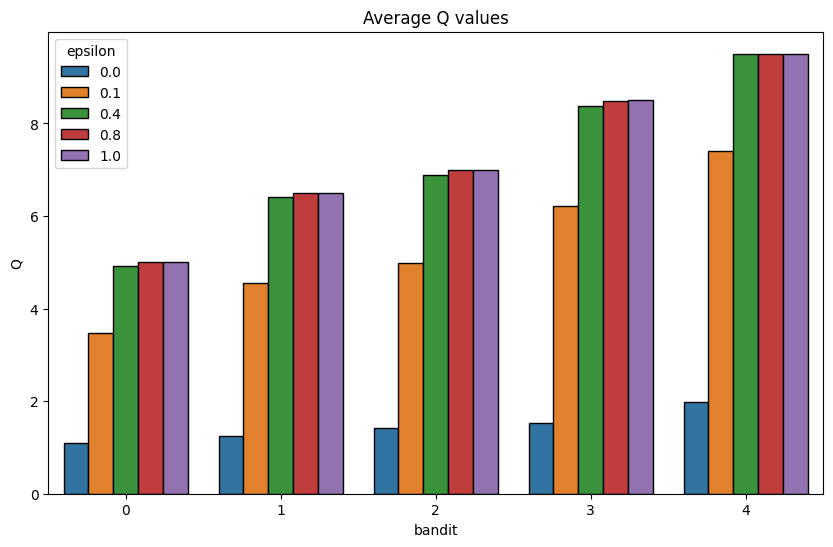

In [10]:
# Ploting a barplot of the evaluated q values
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='bandit', y='Q', hue='epsilon', data=Q_df, ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Average Q values')
plt.show()

# A/B testing using RL algorithm 

This is a small bonus section. The bandit problem can be applied to the very popular A/B testing problem. 

The schema is the following: 

![](media/chapter-2/a_b_test.png)

A user logs on to a website where a backend robot (our `agent`) introduces randomly either green or yellow buttons to click (`actions`). After clicking these buttons, the user then proceeds to the next page where he can shop around. The final value of a shopping carts is relayed back to the agent (`reward` from the `environment`). This information is digested by the agent and the agent stores this information. 

At the end of the experiment run, the agent can say the average spending by customers when clicked on the either green or yellow buttons. 